# tsfresh Feature Engineering and Selection for Cambridge UK Weather Time Series

[tsfresh](https://tsfresh.readthedocs.io/) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 48 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) gradient boosting for Cambridge UK weather time series

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

Install [tsfresh](https://tsfresh.readthedocs.io/) which is currently unavailable on google colab.

**WARNING**: You will need to restart google colab after this install.

In [ ]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 28.2 MB/s 
     |████████████████████████████████| 9.9 MB 23.8 MB/s 
     |████████████████████████████████| 136 kB 57.7 MB/s 
     |████████████████████████████████| 1.3 MB 40.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.10.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompa

Load most of the other required packages.

In [ ]:
import sys
import json
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

%matplotlib inline

env: PYTHONHASHSEED=0




## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in September 2022 and occur every 30 mins.

Shape:


(247777, 39)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247777 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Freq: 30T
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ds                  247633 non-null  datetime64[ns]
 1   y                   247633 non-null  float64       
 2   y_seasonal          247633 non-null  float64       
 3   y_des               247633 non-null  float64       
 4   humidity            247633 non-null  float64       
 5   pressure            247633 non-null  float64       
 6   dew.point           247633 non-null  float64       
 7   dew.point_seasonal  247633 non-null  float64       
 8   dew.point_des       247633 non-null  float64       
 9   wind.x              247633 non-null  float64       
 10  wind.y              247633 non-null  float64       
 11  day.sin             247633 non-null  float64       
 12  day.cos             247633 non-null

None


Summary stats:


,y,y_seasonal,y_des,humidity,pressure,dew.point,dew.point_seasonal,dew.point_des,wind.x,wind.y,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
count,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,2.476330e+05,2.476330e+05,2.476330e+05,...,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000
mean,10.167691,10.167691,0.000000,78.076761,1014.628248,5.917774,5.917774,5.325491e-17,-1.692096e+00,-1.222764e+00,...,0.013908,0.020046,0.001312,0.000226,0.000614,0.020421,0.024629,0.018818,0.003340,0.003340
std,6.511192,5.558909,3.390303,17.543034,11.834168,5.149525,3.772378,3.505249e+00,4.035673e+00,3.717951e+00,...,0.117108,0.140157,0.036204,0.015036,0.024768,0.141437,0.154993,0.135883,0.057693,0.057693
min,-7.000000,-0.278571,-15.055714,20.000000,963.000000,-10.000000,-1.735714,-1.987833e+01,-2.880000e+01,-2.920000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.200000,5.200000,-2.285714,67.000000,1008.000000,2.000000,2.457143,-2.285714e+00,-3.800000e+00,-3.181981e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,9.600000,-0.107143,82.000000,1016.000000,6.000000,5.785714,6.428571e-02,-2.121320e-01,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.645000,14.364286,2.235714,92.000000,1023.000000,9.800000,9.342857,2.435714e+00,1.530808e-16,2.461540e-15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,37.800000,24.817857,23.632857,100.000000,1051.000000,20.900000,13.728571,1.279336e+01,2.050610e+01,2.180000e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Raw data:


,ds,y,y_seasonal,y_des,humidity,pressure,dew.point,dew.point_seasonal,dew.point_des,wind.x,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
ds,,,,,,,,,,,,,,,,,,,,,
2008-08-01 00:00:00,2008-08-01 00:00:00,20.0,16.226667,3.773333,48.6300,1014.666667,8.055,11.803667,-3.748667,-0.999378,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,15.833333,3.666667,47.3425,1014.642857,7.360,11.577333,-4.217333,-0.792970,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,15.626667,3.473333,50.8250,1014.600000,7.775,11.505000,-3.730000,-0.923953,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,15.380000,3.720000,44.9500,1014.714286,6.590,11.359333,-4.769333,-0.934391,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,14.966667,4.133333,46.6000,1014.333333,7.020,11.354667,-4.334667,-0.876812,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-18 22:00:00,2022-09-18 22:00:00,9.2,11.973333,-2.773333,82.0000,1024.000000,6.300,9.453333,-3.153333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 22:30:00,2022-09-18 22:30:00,9.2,11.693333,-2.493333,81.0000,1024.000000,6.100,9.266667,-3.166667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 23:00:00,2022-09-18 23:00:00,9.2,11.486667,-2.286667,81.0000,1024.000000,6.100,8.926667,-2.826667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


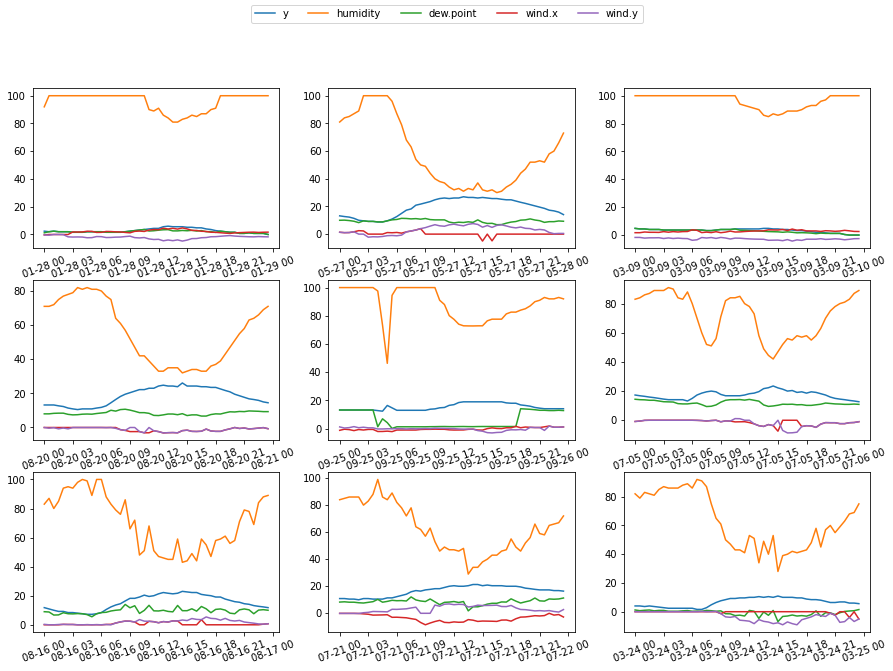

In [ ]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated2022.09.20.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanishMissAnnotated2022.09.20.csv"

df = pd.read_csv(data_loc, parse_dates=['ds'])
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
for column in ['temperature', 'dew.point', 'wind.speed.mean']:
    df[column] /= 10

df['y'] = df['temperature']
    
# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-09-19 00:00:00', :].copy(deep=True)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.
wv = df['wind.speed.mean']
wd_rad = df['wind.bearing.mean'] * np.pi / 180  # Convert to radians

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = 365.2425 * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))


# Add daily spline-based time terms
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


daily_obs = 48
hour_df = pd.DataFrame(
    np.linspace(0, day, daily_obs + 1).reshape(-1, 1),
    columns=["secs"],
)

yearly_obs = int(365.2425 * daily_obs)  # annual observations
month_df = pd.DataFrame(
    np.linspace(0, year, yearly_obs + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(day, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
day_secs_step = int(day / daily_obs)
day_splines_df['secs_since_midnight'] = range(0, day + day_secs_step, day_secs_step)

# pd.concat([hour_df, day_splines_df], axis="columns").plot(x="secs", cmap=plt.cm.tab20b)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

year_splines = periodic_spline_transformer(year, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(year), day_secs_step)



# Add seasonal mean temperature 'y_seasonal'
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * day

df_seasonal_y = df[['y', 'secs_elapsed']].groupby('secs_elapsed').mean('y')
df_seasonal_y.rename(columns={'y': 'y_seasonal'}, inplace=True)

df_seasonal_dp = df[['dew.point', 'secs_elapsed']].groupby('secs_elapsed').mean('dew.point')
df_seasonal_dp.rename(columns={'dew.point': 'dew.point_seasonal'}, inplace=True)

df = pd.merge(df, df_seasonal_y,  on='secs_elapsed')
df = pd.merge(df, df_seasonal_dp, on='secs_elapsed')

df = pd.merge(df, day_splines_df, on='secs_since_midnight')
df = pd.merge(df, year_splines_df, on='secs_elapsed')

# Deseasonalise y ...
df['y_des'] = df['y'] - df['y_seasonal']
df['dew.point_des'] = df['dew.point'] - df['dew.point_seasonal']

df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
cols = ['ds', 'y', 'y_seasonal', 'y_des', 'humidity', 'pressure', \
        'dew.point', 'dew.point_seasonal', 'dew.point_des', \
        'wind.x', 'wind.y', 'day.sin', 'day.cos', 'year.sin', 'year.cos', \
        'day_spline_0', 'day_spline_1', 'day_spline_2', 'day_spline_3', \
        'day_spline_4', 'day_spline_5',  'day_spline_6', 'day_spline_7', \
        'day_spline_8', 'day_spline_9', 'day_spline_10', 'day_spline_11', \
        #'year_spline_0', 'year_spline_1', 'year_spline_2', 'year_spline_3', \
        #'year_spline_4', 'year_spline_5',  'year_spline_6', 'year_spline_7', \
        #'year_spline_8', 'year_spline_9', 'year_spline_10', 'year_spline_11', \
        'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', \
        'cooksd_out', 'isd_3_sigma', 'isd_filled', 'hist_average', \
        'mi_filled', 'mi_spike_interp', 'lin_interp']
df = df[cols]


# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped2022.09.20.csv"
    df.to_csv(data_loc)


print("Shape:")
display(df.shape)
print("\nInfo:")
display(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, cols):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    assert len(data) == 9

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
        for col in cols:
            axs[i].plot(data[i]['ds'], data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


num_plots = 9
days = df.ds.dt.date.sample(n = num_plots).sort_values()
p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]
cols   = ['y', 'humidity', 'dew.point', 'wind.x', 'wind.y']  # 'pressure',    

plot_examples(p_data, cols)


---


### tsfresh Feature Engineering and Selection

tsfresh is a python package which automatically calculates a large number of time series characteristics.  The package contains methods to evaluate the explaining power and importance of these characteristics.  There is a list of characteristics [here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

 * pros
   * produces many potentially useful features
 * cons
   * can be quite slow to run
   * currently unsure about the window lengths to use for calculating features
     * starting with daily period and multiples thereof

Calculate features for the following variables:
 * y_des, humidity, pressure, dew.point, wind.x, wind.y

My general approach is:
 1. run automated feature engineering on data subset
 2. perform feature selection
 3. calculate selected features for full data set
 4. remove redundant features

I will repeat this 2 or 3 times:
 1. for every individual observation
 2. for every sequence of 48ish observations
    * 48, 49 or 50
 3. for every sequence of 96ish observations
    * 96, 97, 98, 99, 100

A few brief notes on data leakage:
  * should be no data leakage when calculating features for every individual observation
    * but potentially a lot of redundant features
  * for the 48ish and/or 96ish observation sequences
    * first extract features on a subset of the training set
    * then extract selected features on
      * full training data
      * validation data
      * testing data
  * **TODO** why not faster changing sequences?
    * 6, 12, 24
  * see docs [here](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) and example notebook [here](https://github.com/blue-yonder/tsfresh/blob/main/notebooks/examples/05%20Timeseries%20Forecasting.ipynb)

---

But first plot ACF and PACF to help decide value of `max_time_shift`:

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


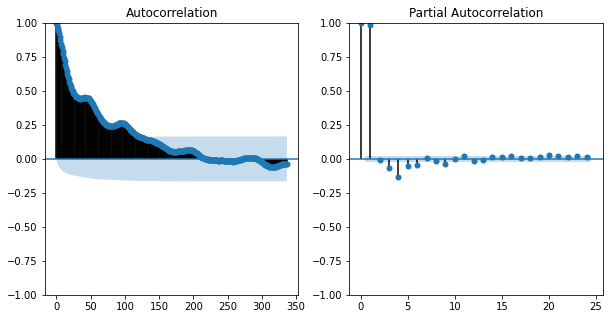

In [ ]:
import statsmodels.api as sm


n = 7000
ycol = 'y_des'
max_lag = 336

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sm.graphics.tsa.plot_acf(df[ycol].head(n),  lags=max_lag, ax=ax[0])
sm.graphics.tsa.plot_pacf(df[ycol].head(n), lags=24, ax=ax[1])
plt.show()

First decline around 36

First peak around 48

Second decline around 72

Second peak around 96

Final decline around 144

Try `max_time_shift` equal to 50 (48-ish) then 100 (96-ish).

---

Now, imports from tsfresh:

In [ ]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import settings

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE



### 1. Generate features for individual observations

A few things to note about tsfresh feature engineering with this data set:
  * unfortunately calculating all features for the full data set would take too long
    * stopped process when eta exceeded 10 hours
    * so calculate and select features from 1 year of data 
      * even using just 2 years of data crashed colab due to out of memory problems :-(
    * then extract selected features for full data set
    * ended up using `tsfresh.settings.EfficientFCParameters` which calculates a faster subset of features
  * strictly speaking we should be using `roll_time_series`
    * see the [05 Timeseries Forecasting](https://github.com/blue-yonder/tsfresh/blob/main/notebooks/examples/05%20Timeseries%20Forecasting.ipynb) example notebook for details
    * not sure what impact this would have on run time

Feature extraction is documented [here](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html).

First, run automated feature engineering:


In [ ]:
df.dropna(inplace=True)
df.loc[:, 'id'] = range(1, len(df) + 1)
df.loc[:, 'datestamp'] = df['ds']

settings_efficient = settings.EfficientFCParameters()

# n =  1000     #  1:19
# n = 10000     # 16 mins
# n = 365 * 48  # 22 mins but crashed at end of run :-(
n = 15000       # 20 mins

cols = ['id', 'datestamp', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
df_features = extract_features(df.loc[:, cols].head(n), 
                               column_id       = "id", 
                               column_sort     = "datestamp",
                               impute_function = impute,
                               default_fc_parameters = settings_efficient)

print("df_features:", df_features.shape)

Feature Extraction: 100%|██████████| 10/10 [18:40<00:00, 112.04s/it]


(15000, 4728)


The initial set of features includes 4,728!

tsfresh feature filtering is documented [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html).

Second, perform feature selection:

In [ ]:
df_target = df['y_des'].head(n)
df_target.index = range(1, len(df_target) + 1)

print("df_features:", df_features.shape)
print("df_target:", df_target.shape)

X_filtered = select_features(df_features, df_target)
print("X_filtered:", X_filtered.shape)

relevance_table = calculate_relevance_table(X_filtered, df_target)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)
print(relevance_table.loc[:, ['feature', 'p_value']][:131])

(15000, 4728)
(15000,)
(15000, 163)
                                                                                              feature  \
feature                                                                                                 
y_des__sum_values                                                                   y_des__sum_values   
dew.point__cwt_coefficients__coeff_0__w_5__widt...  dew.point__cwt_coefficients__coeff_0__w_5__wid...   
dew.point__maximum                                                                 dew.point__maximum   
dew.point__absolute_maximum                                               dew.point__absolute_maximum   
dew.point__root_mean_square                                               dew.point__root_mean_square   
...                                                                                               ...   
wind.y__mean                                                                             wind.y__mean   
wind.y__cwt_coeffic

The initial set of features has reduced from 4,728 to 131.
Briefly, a p-value is calculated for each feature and a multiple testing correction is then applied.

Third, calculate selected features for full data set:

In [ ]:
relevant_settings = settings.from_columns(X_filtered)
print("relevant_settings:\n", 
      json.dumps(relevant_settings, sort_keys=True, indent=4))

cols = ['id', 'datestamp', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
df_features_final = extract_features(df.loc[:, cols], 
                                     column_id       = "id", 
                                     column_sort     = "datestamp",
                                     impute_function = impute,
                                     kind_to_fc_parameters = relevant_settings)

df_features_final['ds'] = df.index
print("df_features_final:", df_features_final.shape)
df_features_final.to_csv('df_features_final.csv')

{'y_des': {'sum_values': None, 'range_count': [{'max': 1, 'min': -1}], 'quantile': [{'q': 0.9}, {'q': 0.3}, {'q': 0.4}, {'q': 0.6}, {'q': 0.7}, {'q': 0.8}, {'q': 0.2}, {'q': 0.1}], 'minimum': None, 'cwt_coefficients': [{'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}, {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}], 'fft_coefficient': [{'attr': 'real', 'coeff': 0}, {'attr': 'abs', 'coeff': 0}], 'maximum': None, 'mean': None, 'median': None, 'absolute_maximum': None, 'abs_energy': None, 'root_mean_square': None, 'benford_correlation': None, 'value_count': [{'value': -1}, {'value': 1}]}, 'dew.point': {'median': None, 'mean': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None, 'quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}, {'q': 0.4}, {'q': 0.6}, {'q': 0.7}, {'q': 0.8}, {'q': 0.9}], 'cwt_coefficients': [{'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}, {'

Feature Extraction: 100%|██████████| 10/10 [25:23<00:00, 152.38s/it]


(247633, 163)


In [ ]:
print(json.dumps(relevant_settings, sort_keys=True, indent=4))

{
    "dew.point": {
        "abs_energy": null,
        "absolute_maximum": null,
        "benford_correlation": null,
        "count_above": [
            {
                "t": 0
            }
        ],
        "count_below": [
            {
                "t": 0
            }
        ],
        "cwt_coefficients": [
            {
                "coeff": 0,
                "w": 2,
                "widths": [
                    2,
                    5,
                    10,
                    20
                ]
            },
            {
                "coeff": 0,
                "w": 10,
                "widths": [
                    2,
                    5,
                    10,
                    20
                ]
            },
            {
                "coeff": 0,
                "w": 20,
                "widths": [
                    2,
                    5,
                    10,
                    20
                ]
            },
            {


**TODO** Remove redundant features:

In [ ]:
# df['y_des'].corr(df['y_des__fft_coefficient__attr_"real"__coeff_0'])
# Create correlation matrix
corr_matrix = df.corr().abs()
# print(corr_matrix)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# print(upper)

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("to_drop:")
print(to_drop)
print(len(to_drop))

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

print("df:", df.shape)

Surprisingly, the number of features has increased from 131 to 163!

Finally, save the tsfresh features:

In [ ]:
df_features_final.to_csv('df_features_final.csv.xz') 


# from google.colab import files
# files.download('df_features_final.csv.xz') 

### 2. Generate features for sequences of 48ish observations

This time try rolling the time series in groups of 48ish observations.
  * 48, 49, 50

Similar process to generating features for individual observations:
 * calculate all features on subset of training data
 * select best features
 * remove redundant features?
 * calculate selected features
   * all train data
   * all valid data
   * all test data
 * remove redundant features?

...

Start by "rolling" the time series then extracting features:

In [ ]:
df.dropna(inplace=True)
# df.loc[:, 'id'] = range(1, len(df) + 1)
df.loc[:, 'id'] = 'fubar'
df.loc[:, 'datestamp'] = df['ds']

settings_efficient = settings.EfficientFCParameters()

n =  100        #  approx. 14 secs
n = 1000        #  2 mins 37
n = 10000       # 32 mins
n = 365 * 48    # .. mins but crashed at end of run :-(
# n = 15000     # .. mins
cols = ['id', 'datestamp', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
#print(df.loc[:, cols].head())

#X, y = make_forecasting_frame(df['y_des'].head(n), 
#                              kind = 'y_des',
#                              rolling_direction = 1,
#                              max_timeshift = 50)
#print("X:", X.shape, sep='\n')
#display(X)


#df_features = extract_features(X.head(n), 
#                               column_id       = "id", 
#                               column_sort     = "time",
#                               column_value    = "value",
#                               impute_function = impute,
#                               default_fc_parameters = settings_efficient)
#print("df_features:", df_features.shape)
#display(df_features)
#stop()


df_rolled = roll_time_series(df.loc[:, cols].head(n), 
                             column_id     = 'id', 
                             column_sort   = 'datestamp',
                             max_timeshift = 50, 
                             min_timeshift = 50)

print("df_rolled:", df_rolled.shape, sep='\n')
display(df_rolled)
#stop()

df_features = extract_features(df_rolled, 
                               column_id       = "id", 
                               column_sort     = "datestamp",
                               impute_function = impute,
                               default_fc_parameters = settings_efficient)

print("df_features:", df_features.shape)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


df_rolled:
(507450, 8)


,id,datestamp,y_des,humidity,pressure,dew.point,wind.x,wind.y
0,"(fubar, 2008-08-02 01:00:00)",2008-08-01 00:00:00,3.773333,48.6300,1014.666667,8.055,-0.999378,-0.999378
1,"(fubar, 2008-08-02 01:00:00)",2008-08-01 00:30:00,3.666667,47.3425,1014.642857,7.360,-0.792970,-0.792970
2,"(fubar, 2008-08-02 01:00:00)",2008-08-01 01:00:00,3.473333,50.8250,1014.600000,7.775,-0.923953,-0.923953
3,"(fubar, 2008-08-02 01:00:00)",2008-08-01 01:30:00,3.720000,44.9500,1014.714286,6.590,-0.934391,-0.934391
4,"(fubar, 2008-08-02 01:00:00)",2008-08-01 02:00:00,4.133333,46.6000,1014.333333,7.020,-0.876812,-0.876812
...,...,...,...,...,...,...,...,...
507445,"(fubar, 2009-02-26 01:30:00)",2009-02-25 23:30:00,2.685714,95.0000,1025.000000,6.000,-2.616295,-2.616295
507446,"(fubar, 2009-02-26 01:30:00)",2009-02-26 00:00:00,2.371429,95.0000,1025.000000,5.600,-2.828427,-2.828427
507447,"(fubar, 2009-02-26 01:30:00)",2009-02-26 00:30:00,3.085714,95.0000,1025.000000,6.000,-3.181981,-3.181981
507448,"(fubar, 2009-02-26 01:30:00)",2009-02-26 01:00:00,2.942857,95.0000,1025.000000,5.600,-3.535534,-3.535534


Feature Extraction: 100%|██████████| 10/10 [28:36<00:00, 171.66s/it]


df_features: (9950, 4698)


...

Next, select features:

In [ ]:
#df_features = df_features.set_index(df_features.index.map(lambda x: x[1]), drop=True)
#df_features.index.name = "ds"
#df_features = df_features[~df_features.index.duplicated(keep='first')]
#df_features = df_features.asfreq(freq='30min')

#print("df_features:", df_features.shape)
#print(df_features.index)

#print(df.head())
#df_target = df[df_features.index, 'y_des']
target_cols = ['ds','y_des']
df_target = pd.merge(df[target_cols], 
                     df_features, 
                     left_on  = df.index, 
                     right_on = df_features.index)[target_cols]
df_target.set_index('ds', drop=True, inplace=True)
df_target = df_target[~df_target.index.duplicated(keep='first')]
df_target = df_target.asfreq(freq='30min')

df_target.dropna(inplace=True)
df_features.dropna(inplace=True)
print("df_features:", df_features.shape)
print("df_target:", df_target.shape)

X_filtered = select_features(df_features, df_target['y_des'])#, fdr_level=0.0005)
print("X_filtered:", X_filtered.shape)

relevance_table = calculate_relevance_table(X_filtered, df_target['y_des'])
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)
print(relevance_table.loc[:, ['feature', 'p_value']])

df_features: (9950, 4698)
df_target: (9950, 1)
X_filtered: (9950, 1994)
                                                                                              feature  \
feature                                                                                                 
y_des__sum_values                                                                   y_des__sum_values   
dew.point__count_above__t_0                                               dew.point__count_above__t_0   
dew.point__number_crossing_m__m_-1                                 dew.point__number_crossing_m__m_-1   
y_des__range_count__max_0__min_-1000000000000.0       y_des__range_count__max_0__min_-1000000000000.0   
y_des__range_count__max_1000000000000.0__min_0         y_des__range_count__max_1000000000000.0__min_0   
...                                                                                               ...   
humidity__variation_coefficient                                       humidity__variatio

...

Finally, calculate features and remove redundant featues for each data set:
 * train
 * valid
 * test

In [ ]:
#df_features = df_features.set_index(df_features.index.map(lambda x: x[1]), drop=True)
#df_features.index.name = "ds"
#df_features = df_features[~df_features.index.duplicated(keep='first')]
#df_features = df_features.asfreq(freq='30min')

#print("df_features:", df_features.shape)
#print(df_features.index)

#print(df.head())
#df_target = df[df_features.index, 'y_des']
print("X_filtered:", X_filtered.shape)
cols = ['y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
X_filtered = pd.merge(df[cols], 
                      X_filtered, 
                      left_on  = df.index, 
                      right_on = X_filtered.index)
#df_target.set_index('ds', drop=True, inplace=True)
#df_target = df_target[~df_target.index.duplicated(keep='first')]
#df_target = df_target.asfreq(freq='30min')

#df_target.dropna(inplace=True)
#df_features.dropna(inplace=True)
print("X_filtered:", X_filtered.shape)
#print("df_target:", df_target.shape)


# Create correlation matrix
corr_matrix = X_filtered.corr().abs()
# print("corr_matrix:", corr_matrix, sep='\n')

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# print("upper:", upper, sep='\n')

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("to_drop:", to_drop, sep='\n')
print(len(to_drop))

# Drop features 
X_filtered.drop(to_drop, axis=1, inplace=True)
print("X_filtered:", X_filtered.shape)

df_features: (9950, 4698)
df_features: (9950, 4705)


KeyboardInterrupt: ignored


### 3. Generate features for sequences of 96ish observations

This time try rolling the time series in groups of 48ish observations.
  * 96, 97, 98, 99, 100

Same steps as before:
 * calculate all features on subset of training data
 * select best features
 * remove redundant features?
 * calculate selected features
   * all train data
   * all valid data
   * all test data
 * remove redundant features?
 
...

...

---

### Conclusion

**TODO** Compare number and type of features from:
  * individual observations
  * 48ish observations
  * 96ish observations

131 features is quite a lot to process.  Unfortunately, dependencies between the features are not considered in the tsfresh feature selection step.
Calcualting [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) could fix this problem at a much higher computational cost.

Check the [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) notebook for results of using these new features.

Alternatives to tsfresh include:
 * [catch22](https://github.com/DynamicsAndNeuralSystems/catch22) CAnonical Time-series CHaracteristics.
   * unfortunately, no version of catch22 will install on google colab at this time :-(
 * [Rob Hyndman's](https://robjhyndman.com/) [tsfeatures](https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html)
   * which has been [ported to python](https://github.com/Nixtla/tsfeatures)
 * Table 1 from [this paper](https://arxiv.org/pdf/2011.10545.pdf) has additional suggestions which I have not explored

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

IPython version:
7.9.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
tsfresh,0.19.0
seaborn,0.11.2
scikit-learn,1.0.2
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
google,2.0.3


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2249.998
BogoMIPS:            4499.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignss

In [ ]:
!date

Wed Oct 26 21:14:21 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}